# Needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import time
from scipy import stats
import seaborn as sbn
import pandas as pd
import h5py
import os

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [4]:
from keras.layers import Lambda, Input, Dense, Dropout, AveragePooling2D, Flatten, Conv2D
from keras.layers import MaxPooling2D, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.losses import mse, binary_crossentropy, mean_absolute_percentage_error
from keras.utils import plot_model,to_categorical
from keras import backend as K
from keras import callbacks
#from sklearn.preprocessing import LabelEncoder,OneHotEncoder,image,label_binarize
from keras.utils import plot_model
from keras.optimizers import SGD, Adam
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import roc_curve,roc_auc_score,mean_squared_error
#from keras.applications.resnet50 import ResNet50
import tensorflow as tf
import keras.losses as kLoss
from keras import optimizers

2025-02-28 13:00:23.671018: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-28 13:00:23.743534: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-28 13:00:23.743979: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-28 13:00:24.508794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
print('numpy version:', np.__version__)
print('matplotlib version:', mpl.__version__)
print('tensorflow version:', tf.__version__)

# Check if gpu is available
if tf.test.is_gpu_available():
    device = 'gpu'
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

numpy version: 1.24.4
matplotlib version: 3.4.3
tensorflow version: 2.13.1
Using CPU


In [5]:
print('numpy version:', np.__version__)
print('matplotlib version:', mpl.__version__)
print('torch version:', torch.__version__)

# Check if gpu is available
if torch.cuda.is_available():
    device = 'gpu'
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')


numpy version: 1.24.3
matplotlib version: 3.4.3
torch version: 2.4.1+cu121
Using CPU


# Reading data

In [27]:
images = np.load('../data/TNGgalaxies_28_02/images.npy')
labels = np.load('../data/TNGgalaxies_28_02/labels.npy')

In [28]:
print(f'There are {len(np.where(np.isnan(images) == True)[0])} nans in images')
print(f'There are {len(np.where(np.isnan(labels) == True)[0])} nans in labels')

There are 3086 nans in images
There are 0 nans in labels


In [29]:
images = np.nan_to_num(images, nan=0)

In [9]:
images = np.moveaxis(images, 1, -1)

In [30]:
images = images[:100,:,:,:]
labels = labels[:100,:]

In [31]:
nobs,nch, npix, _ = images.shape

In [32]:
np.random.seed(28890)
random_ind = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_size = int(0.7 * nobs)
val_size = int(0.2 * nobs)
test_size = nobs - train_size - val_size

train_ind = random_ind[:train_size]
val_ind = random_ind[train_size:(val_size + train_size)]
test_ind = random_ind[-test_size:]

In [33]:
x_trainset = images[train_ind,:,:,:]
x_valset = images[val_ind,:,:,:]
x_testset = images[test_ind,:,:,:]

y_trainset = np.log10(labels[train_ind,0,:])
y_valset = np.log10(labels[val_ind,0,:])
y_testset = np.log10(labels[test_ind,0,:])

In [34]:
min_x = np.min(x_trainset)
max_x = np.max(x_trainset)

min_y = np.min(y_trainset, axis = 0)
max_y = np.max(y_trainset, axis = 0)

In [35]:
x_trainset = (x_trainset - min_x) / (max_x - min_x)
x_valset = (x_valset - min_x) / (max_x - min_x)
x_testset = (x_testset - min_x) / (max_x - min_x)

y_trainset = (y_trainset - min_y) / (max_y - min_y)
y_valset = (y_valset - min_y) / (max_y - min_y)
y_testset = (y_testset - min_y) / (max_y - min_y)

In [36]:
min_x

-73866.63006661664

# Playing with CNNs

In [37]:
# network parameters
input_shape = (nch,npix, npix) # Input shape (#rows, #cols, #channels)
actFunction = 'relu'

# Hidden layers dimensions
intermediate_dim1 = 500
intermediate_dim2 = 400
intermediate_dim3 = 300
intermediate_dim4 = 200
output_dim        = y_trainset.shape[1]

## First let's check that it overfit 1 batch

* It seems to converge to MSE = 0.0451 (without batch normalization nor dropout)

In [38]:
class ConvNet(nn.Module):
    def __init__(self, input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction):
        super(ConvNet, self).__init__()
        
        # Cálculo de la cantidad de canales de entrada (esto depende de input_shape)
        self.input_channels = input_shape[0]  # Ejemplo: (3, 64, 64), sería 3 canales de entrada
        
        # Definición de las capas de la red
        self.conv1 = nn.Conv2d(self.input_channels, 5, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 15, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(15, 30, kernel_size=5, stride=1, padding=2)
        
        # Capa de Flatten
        self.flatten = nn.Flatten()
        
        # Capas completamente conectadas (fully connected)
        self.fc1 = nn.Linear(30 * input_shape[1] // 8 * input_shape[2] // 8, intermediate_dim1)  # Tamaño de salida después de 3 MaxPooling
        self.fc2 = nn.Linear(intermediate_dim1, intermediate_dim2)
        self.fc3 = nn.Linear(intermediate_dim2, intermediate_dim3)
        self.fc4 = nn.Linear(intermediate_dim3, intermediate_dim4)
        self.fc5 = nn.Linear(intermediate_dim4, output_dim)
        
        # Función de activación
        self.actFunction = actFunction

    def forward(self, x):
        # Primera capa convolucional
        x = self.conv1(x)
        x = self.actFunction(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)
        
        # Segunda capa convolucional
        x = self.conv2(x)
        x = self.actFunction(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)
        
        # Tercera capa convolucional
        x = self.conv3(x)
        x = self.actFunction(x)
        x = F.max_pool2d(x, 2)  # MaxPooling (2x2)
        
        # Aplanamiento
        x = self.flatten(x)
        
        # Capas completamente conectadas
        x = self.actFunction(self.fc1(x))
        x = self.actFunction(self.fc2(x))
        x = self.actFunction(self.fc3(x))
        x = self.fc4(x)  # Capa final antes de la salida (sin activación, o con 'linear' como en el código original)
        x = self.fc5(x)  # Capa de salida
        
        return x

In [56]:

actFunction = torch.relu  # Función de activación ReLU

# Crear el modelo
model = ConvNet(input_shape, intermediate_dim1, intermediate_dim2, intermediate_dim3, intermediate_dim4, output_dim, actFunction)

# Mostrar la estructura del modelo
print(model)

ConvNet(
  (conv1): Conv2d(8, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 15, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(15, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=7680, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=20, bias=True)
)


In [40]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        # Convertir las imágenes y etiquetas a tensores
        image = torch.tensor(self.x_data[idx], dtype=torch.float32)
        label = torch.tensor(self.y_data[idx], dtype=torch.float32)
        return image, label

In [51]:
# Crear los DataLoaders para entrenamiento y validación
train_dataset = CustomDataset(x_trainset, y_trainset)
val_dataset = CustomDataset(x_valset, y_valset)
test_dataset = CustomDataset(x_testset, y_testset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [57]:
# 4. Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()  # Para un problema de regresión o imagen de salida continua
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [45]:
data_iter = iter(dataloader)  # Crear un iterador del DataLoader
x_batch, y_batch = next(data_iter) 

In [58]:
num_epochs = 100

train_loss = []
val_loss = []
for epoch in range(num_epochs):
    # Entrenamiento
    model.train()  # Configura el modelo en modo entrenamiento
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        # Zero gradientes
        optimizer.zero_grad()

        # Paso hacia adelante
        outputs = model(inputs)

        # Calcular la pérdida
        loss = criterion(outputs, labels)

        # Paso hacia atrás (backpropagation)
        loss.backward()

        # Actualizar los pesos
        optimizer.step()

        # Sumar la pérdida del lote
        running_train_loss += loss.item()

    # Promedio de la pérdida de entrenamiento
    avg_train_loss = running_train_loss / len(train_loader)
    train_loss.append(avg_train_loss)
    
    # Validación
    model.eval()  # Configura el modelo en modo evaluación
    running_val_loss = 0.0
    with torch.no_grad():  # No calculamos gradientes en validación
        for inputs, labels in val_loader:

            # Paso hacia adelante (sin gradientes)
            outputs = model(inputs)

            # Calcular la pérdida
            loss = criterion(outputs, labels)
            # Sumar la pérdida de validación
            running_val_loss += loss.item()

    # Promedio de la pérdida de validación
    avg_val_loss = running_val_loss / len(val_loader)
    val_loss.append(avg_val_loss)
    
    # Imprimir estadísticas de la época
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}")

Epoch [1/100], Train Loss: 0.3067, Validation Loss: 0.2896
Epoch [2/100], Train Loss: 0.1682, Validation Loss: 0.0575
Epoch [3/100], Train Loss: 0.0638, Validation Loss: 0.1365
Epoch [4/100], Train Loss: 0.0999, Validation Loss: 0.0930
Epoch [5/100], Train Loss: 0.0617, Validation Loss: 0.0593
Epoch [6/100], Train Loss: 0.0484, Validation Loss: 0.0699
Epoch [7/100], Train Loss: 0.0547, Validation Loss: 0.0825
Epoch [8/100], Train Loss: 0.0443, Validation Loss: 0.0583
Epoch [9/100], Train Loss: 0.0548, Validation Loss: 0.0601
Epoch [10/100], Train Loss: 0.0476, Validation Loss: 0.0803
Epoch [11/100], Train Loss: 0.0577, Validation Loss: 0.0564
Epoch [12/100], Train Loss: 0.0459, Validation Loss: 0.0500
Epoch [13/100], Train Loss: 0.0427, Validation Loss: 0.0710
Epoch [14/100], Train Loss: 0.0410, Validation Loss: 0.0793
Epoch [15/100], Train Loss: 0.0492, Validation Loss: 0.0590
Epoch [16/100], Train Loss: 0.0452, Validation Loss: 0.0492
Epoch [17/100], Train Loss: 0.0463, Validation Lo

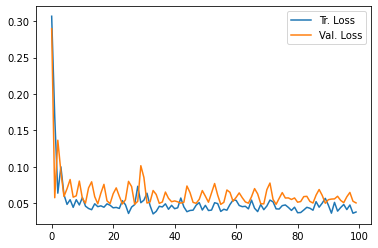

In [59]:
plt.plot(train_loss, label = 'Tr. Loss')
plt.plot(val_loss, label = 'Val. Loss')
plt.legend()

In [63]:
model.eval()  # Asegúrate de que el modelo esté en modo evaluación
y_predicted = []  # Lista para almacenar las predicciones

# Desactivamos el cálculo de gradientes durante la predicción
with torch.no_grad():
    for inputs, _ in test_loader:  # Usamos _ porque no necesitamos las etiquetas en x_testset

        # Hacer predicciones
        outputs = model(inputs)

        # Almacenar las predicciones (por ejemplo, como numpy arrays)
        y_predicted.append(outputs.numpy())  # Si necesitas los resultados como numpy

# Convertir la lista de predicciones en un solo array
y_predicted = np.concatenate(y_predicted, axis=0)

print(y_predicted.shape)  # Esto te dará la forma de las predicciones


(10, 20)


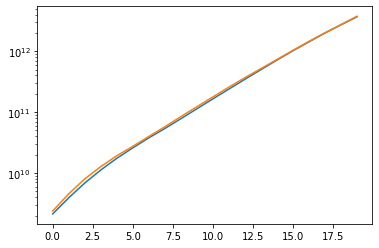

In [70]:
i= 5
plt.plot(10**(y_predicted[i,:] * (max_y - min_y) + min_y))
plt.plot(10**(y_testset[i,:] * (max_y - min_y) + min_y))
plt.yscale('log')

In [120]:
# build model
model = Sequential()

model.add(Conv2D(filters = 5, kernel_size = (5,5), strides = 1 , padding = 'same', input_shape = input_shape))
#model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 15, kernel_size = (5,5), strides = 1 , padding = 'same'))
#model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 30, kernel_size = (5,5), strides = 1 , padding = 'same'))
#model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Dropout(0.2)) 
model.add(Flatten())

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim1, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim2, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim3, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim4, activation = 'linear'))

model.add(Dense(output_dim, name = 'output'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 128, 5)       1005      
                                                                 
 batch_normalization_7 (Bat  (None, 128, 128, 5)       20        
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 128, 128, 5)       0         
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 64, 64, 5)         0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 15)        1890      
                                                                 
 batch_normalization_8 (Bat  (None, 64, 64, 15)       

In [122]:
# instantiate model
optimizer = optimizers.Adam(learning_rate = 1e-5, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(optimizer = optimizer, loss = 'mse', metrics=['mae','mse'])

In [103]:
batch_size = 32
epochs     = 250
history = model.fit(x_trainset[:batch_size], y_trainset[:batch_size],
                   epochs = epochs,
                   validation_data = (x_trainset[:batch_size], y_trainset[:batch_size]))

Epoch 1/250
1/1 [==============================] - 1s 1s/step - loss: 0.3322 - mae: 0.5282 - mse: 0.3322 - val_loss: 0.3210 - val_mae: 0.5184 - val_mse: 0.3210
Epoch 2/250
1/1 [==============================] - 0s 265ms/step - loss: 0.3210 - mae: 0.5184 - mse: 0.3210 - val_loss: 0.3104 - val_mae: 0.5089 - val_mse: 0.3104
Epoch 3/250
1/1 [==============================] - 0s 275ms/step - loss: 0.3104 - mae: 0.5089 - mse: 0.3104 - val_loss: 0.3009 - val_mae: 0.5002 - val_mse: 0.3009
Epoch 4/250
1/1 [==============================] - 0s 345ms/step - loss: 0.3009 - mae: 0.5002 - mse: 0.3009 - val_loss: 0.2919 - val_mae: 0.4918 - val_mse: 0.2919
Epoch 5/250
1/1 [==============================] - 0s 314ms/step - loss: 0.2919 - mae: 0.4918 - mse: 0.2919 - val_loss: 0.2837 - val_mae: 0.4839 - val_mse: 0.2837
Epoch 6/250
1/1 [==============================] - 0s 291ms/step - loss: 0.2837 - mae: 0.4839 - mse: 0.2837 - val_loss: 0.2761 - val_mae: 0.4765 - val_mse: 0.2761
Epoch 7/250
1/1 [========

(0.0, 1.0)

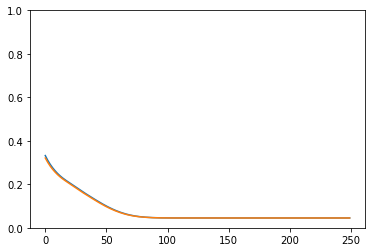

In [104]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,1)

In [105]:
y_predicted = model.predict(x_trainset[:batch_size]) * (max_y - min_y) + min_y

1/1 [==============================] - 0s 121ms/step


In [109]:
y_trainset.shape

(70, 20)

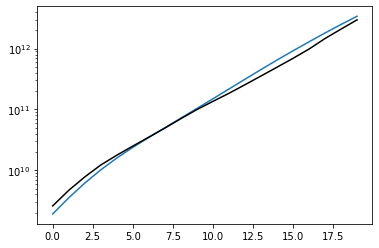

In [112]:
i = 22
plt.plot(10**(y_predicted[i,:]))
plt.plot(10**(y_trainset[i,:] * (max_y - min_y) + min_y), c = 'black')
plt.yscale('log')

## Now let's play the real game

* Seems to converge to MSE = 0.054 (without batch normalization nor dropout)

In [129]:
# build model
model = Sequential()

model.add(Conv2D(filters = 5, kernel_size = (5,5), strides = 1 , padding = 'same', input_shape = input_shape))
model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 15, kernel_size = (5,5), strides = 1 , padding = 'same'))
model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 30, kernel_size = (5,5), strides = 1 , padding = 'same'))
model.add(BatchNormalization())
model.add(Activation(actFunction))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2)) 
model.add(Flatten())

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim1, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim2, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim3, activation = actFunction))

#model.add(BatchNormalization())
model.add(Dense(intermediate_dim4, activation = 'linear'))

model.add(Dense(output_dim, name = 'output'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 128, 128, 5)       1005      
                                                                 
 batch_normalization_21 (Ba  (None, 128, 128, 5)       20        
 tchNormalization)                                               
                                                                 
 activation_24 (Activation)  (None, 128, 128, 5)       0         
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 64, 64, 5)         0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 15)        1890      
                                                                 
 batch_normalization_22 (Ba  (None, 64, 64, 15)       

In [130]:
# instantiate model
optimizer = optimizers.Adam(learning_rate = 1e-5, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
model.compile(optimizer = optimizer, loss = 'mse', metrics=['mae','mse'])

In [135]:
batch_size = 32
epochs     = 250
history = model.fit(x_trainset, y_trainset,
                   epochs = epochs,
                   callbacks = [mc],
                   validation_data = (x_valset, y_valset))

Epoch 1/250
3/3 [==============================] - ETA: 0s - loss: 0.0530 - mae: 0.1808 - mse: 0.0530
Epoch 1: val_loss did not improve from 0.05286
3/3 [==============================] - 1s 250ms/step - loss: 0.0530 - mae: 0.1808 - mse: 0.0530 - val_loss: 0.0669 - val_mae: 0.2041 - val_mse: 0.0669
Epoch 2/250
3/3 [==============================] - ETA: 0s - loss: 0.0530 - mae: 0.1823 - mse: 0.0530
Epoch 2: val_loss did not improve from 0.05286
3/3 [==============================] - 1s 236ms/step - loss: 0.0530 - mae: 0.1823 - mse: 0.0530 - val_loss: 0.0684 - val_mae: 0.2066 - val_mse: 0.0684
Epoch 3/250
3/3 [==============================] - ETA: 0s - loss: 0.0493 - mae: 0.1753 - mse: 0.0493
Epoch 3: val_loss did not improve from 0.05286
3/3 [==============================] - 1s 239ms/step - loss: 0.0493 - mae: 0.1753 - mse: 0.0493 - val_loss: 0.0696 - val_mae: 0.2086 - val_mse: 0.0696
Epoch 4/250
3/3 [==============================] - ETA: 0s - loss: 0.0516 - mae: 0.1799 - mse: 0.051

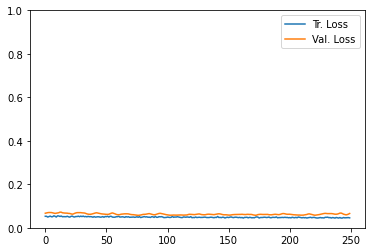

In [136]:
plt.plot(history.history['loss'], label = 'Tr. Loss')
plt.plot(history.history['val_loss'], label = 'Val. Loss')
plt.ylim(0,1)
plt.legend()

In [137]:
y_predicted = model.predict(x_testset) * (max_y - min_y) + min_y

1/1 [==============================] - 0s 29ms/step


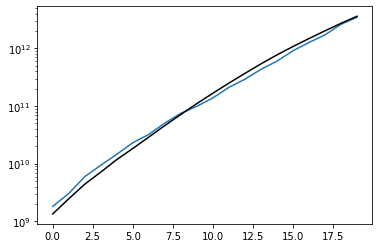

In [138]:
i = 4
plt.plot(10**(y_predicted[i,:]))
plt.plot(10**(y_testset[i,:] * (max_y - min_y) + min_y), c = 'black')
plt.yscale('log')

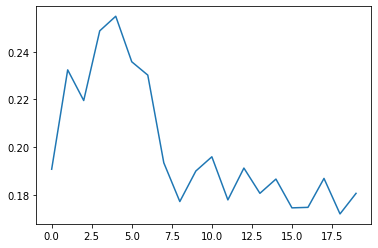

In [143]:
plt.plot(np.sqrt(np.sum((y_testset * (max_y - min_y) + min_y - y_predicted)**2, axis = 0) / len(y_testset)))